# Machine Learning for phase transition recognition in Ising model using autocorrelation

In this notebook I evaluated the performance of a neural network to recognize phase transition in the ising model.

Activate GPU in edit --> Notebook Settings

# Data Collection

In [0]:
!wget https://github.com/francescobodria/Machine-Learning-for-Phase-Recognition/raw/master/HPC/Session.mat

--2019-06-04 20:02:56--  https://github.com/francescobodria/Machine-Learning-for-Phase-Recognition/raw/master/HPC/Session.mat
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francescobodria/Machine-Learning-for-Phase-Recognition/master/HPC/Session.mat [following]
--2019-06-04 20:02:56--  https://raw.githubusercontent.com/francescobodria/Machine-Learning-for-Phase-Recognition/master/HPC/Session.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87168088 (83M) [application/octet-stream]
Saving to: ‘Session.mat.1’

Session.mat.1       100%[===================>]  83.13M   311MB/s    in 0.3s    

2019-06

In [0]:
import scipy.io as sio

For ising data I used a montecarlo simulation temperature dependent, created by me on the HPC cluster

In [0]:
data = sio.loadmat('/content/Session.mat')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [0]:
data

{'N': array([[30]], dtype=uint8),
 'Tc': array([[2.26918531]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Oct 11 12:22:22 2018',
 '__version__': '1.0',
 'output_2_ext': array([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]], dtype=uint8),
 'output_2_lim': array([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]], dtype=uint8),
 'test_T': array([[1.        , 1.02684564, 1.05369128, 1.08053691, 1.10738255,
         1.13422819, 1.16107383, 1.18791946, 1.2147651 , 1.24161074,
         1.26845638, 1.29530201, 1.32214765, 1.34899329, 1.37583893,
         1.40268456, 1.4295302 , 1.45637584, 1.48322148, 1.51006711,
         1.53691275, 1.56375839, 1.59060403, 1.61744966, 1.6442953 ,
         1.67114094, 1.69798658, 1.72483221, 1.75167785, 1.77852349,
         1.80536913, 1.83221477, 1.8590604 , 1.88590604, 1.91275168,
         1.93959732, 1.96

In [0]:
data['train_ext_T']

array([[0.00000000e+00, 8.00032001e-05, 1.60006400e-04, ...,
        4.99983999e+00, 4.99992000e+00, 5.00000000e+00]])

In [0]:
training = data['train_ext_out_data']
data['train_ext_out_magn']

array([[ 1.        ,  1.        ,  1.        , ..., -0.01555556,
         0.21111111, -0.02444444]])

In [0]:
output = data['output_2_ext']
data['output_2_ext']

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

Text(0, 0.5, 'Magnetizzazione Media')

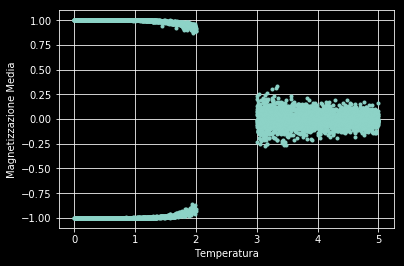

In [0]:
red = np.linspace(0,data['train_ext_T'].shape[1]-1,5000).astype(int)
X = data['train_ext_T'][:,red].ravel()
Y = data['train_ext_out_magn'][:,red].ravel()
plt.plot(X,Y,'.');
plt.grid()
plt.xlabel('Temperatura')
plt.ylabel('Magnetizzazione Media')

## Training 

In [0]:
perc = 0.15
p = np.random.permutation(len(training))
training = training[p]
output = output[p]

l = int(len(training)*perc)

validation = training[:l,:]
training = training[l:,:]

output_validation = output[:l,:]
output_training = output[l:,:]

In [0]:
import tensorflow as tf

# tf Graph Input and Output
x = tf.placeholder(tf.float32, [None, 900], name='x') 
y = tf.placeholder(tf.float32, [None, 2], name='y') 

def Net(x,weights,biases):
    out = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['w1']), biases['b1']),name='first_layer')
    out = tf.add(tf.matmul(out, weights['w2']), biases['b2'], name='second_layer')
    return out

# Set model weights
weights = {
    'w1': tf.Variable(tf.random_normal([900, 100]),name='W1'),
    'w2': tf.Variable(tf.random_normal([100, 2]),name='W2'),
}
biases = {
    'b1': tf.Variable(tf.random_normal([100]),name='b1'),
    'b2': tf.Variable(tf.random_normal([2]),name='b2'),
}

out = Net(x, weights, biases)

# Minimize error using cross entropy
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=out),name='cost')

regularizer_1 = tf.nn.l2_loss(weights['w1'])
regularizer_2 = tf.nn.l2_loss(weights['w2'])
n_weights = int(np.prod(weights['w1'].shape)+np.prod(weights['w2'].shape))

l = 15.0
cost = tf.reduce_mean(cost + l/n_weights * (tf.add(regularizer_1,regularizer_2)))

learning_rate = 0.3
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_out = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_out, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

# Let the Training Begin

In [0]:
check_validation = 2
batch_size = 10
max_iteration = 30

with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    step = 0
    loss, acc = sess.run([cost, accuracy], feed_dict={x: training,\
                                                      y: output_training})
    loss2, acc2 = sess.run([cost, accuracy], feed_dict={x: validation,\
                                                        y: output_validation})
    print ("Iter " + str(step) + ", Cost= " + \
               "{:.5f}".format(loss) + ", Training Accuracy= " + \
               "{:.5f}".format(acc) + ", Validation Accuracy= " + \
               "{:.5f}".format(acc2))

    j = 0
    best_acc = acc2
    # Keep training until reach max iterations
    while step < max_iteration:
        
        #shuffle data
        p = np.random.permutation(len(training))
        training = training[p]
        output_training = output_training[p]
        
        for i in range(len(training)//batch_size):
        
            batch_x = training[i*batch_size:(i+1)*batch_size]
            batch_y = output_training[i*batch_size:(i+1)*batch_size]
            
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        # Calculate batch loss and accuracy
        loss, acc = sess.run([cost, accuracy], feed_dict={x: training,\
                                                          y: output_training})
        loss2, acc2 = sess.run([cost, accuracy], feed_dict={x: validation,\
                                                            y: output_validation})
        
        print ("Iter " + str(step+1) + ", Cost= " + \
                   "{:.5f}".format(loss) + ", Training Accuracy= " + \
                   "{:.5f}".format(acc) + ", Validation Accuracy= " + \
                   "{:.5f}".format(acc2))
        
        if acc2 > best_acc:
            j = 0
            best_acc = acc2
            saver.save(sess,'/content/Tensorflow_ext_model/ext_model')
        else: j+=1
        
        if j == check_validation: 
            print('Check Validation Reached')
            break
        step += 1
    
    if step == max_iteration: print('Max Iterations Reached')

Iter 0, Cost= 10.06883, Training Accuracy= 0.48995, Validation Accuracy= 0.48173
Iter 1, Cost= 5.25000, Training Accuracy= 0.88329, Validation Accuracy= 0.85707
Iter 2, Cost= 3.32907, Training Accuracy= 0.98584, Validation Accuracy= 0.97307
Iter 3, Cost= 2.11657, Training Accuracy= 0.99958, Validation Accuracy= 0.99587
Iter 4, Cost= 1.38006, Training Accuracy= 1.00000, Validation Accuracy= 0.99867
Iter 5, Cost= 0.90286, Training Accuracy= 1.00000, Validation Accuracy= 0.99973
Iter 6, Cost= 0.59109, Training Accuracy= 1.00000, Validation Accuracy= 0.99987
Iter 7, Cost= 0.38734, Training Accuracy= 1.00000, Validation Accuracy= 1.00000
Iter 8, Cost= 0.25422, Training Accuracy= 1.00000, Validation Accuracy= 1.00000
Iter 9, Cost= 0.16727, Training Accuracy= 1.00000, Validation Accuracy= 1.00000
Check Validation Reached


## Testing

In [0]:
testing = data['test_out_data']
print(testing.shape)

(150, 900, 1000)


Text(0, 0.5, 'Magnetizzazione Media')

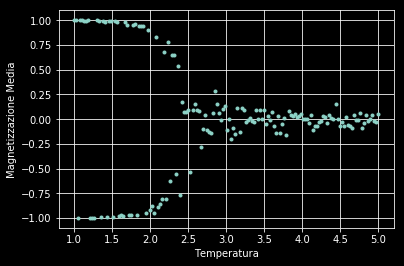

In [0]:
X = data['test_T'].ravel()
Y = data['test_in_magn'][:,0]
plt.plot(X,Y,'.');
plt.grid()
plt.xlabel('Temperatura')
plt.ylabel('Magnetizzazione Media')

In [0]:
out = tf.sigmoid(out)

In [0]:
import time
start = time.time()

with tf.Session() as sess:
    saver.restore(sess,'/content/Tensorflow_ext_model/ext_model')
    avg_ext = np.zeros([150,2])
    for i in range(150):
        value = np.zeros([1000,2])
        for j in range(testing.shape[2]):
            value[j,:]=sess.run(out, feed_dict={x: np.reshape(np.array(testing[i,:,j]),(1,900))})
        avg_ext[i,:]=(np.mean(value,axis=0))

end = time.time()
print(end - start)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/Tensorflow_ext_model/ext_model
92.1369047164917


Text(0, 0.5, 'Media Segnale Rete')

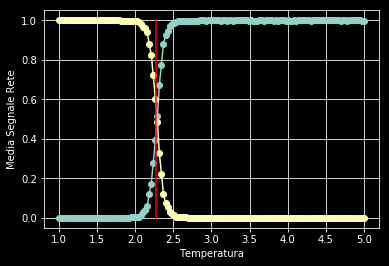

In [0]:
X = data['test_T']
Y = avg_ext
plt.plot(X.ravel(),avg_ext[:,0],'-o')
plt.plot(X.ravel(),avg_ext[:,1],'-o')
vec = np.linspace(0,1,100)
plt.plot(np.ones((1,100)).ravel()*2/np.log(1+np.sqrt(2)),vec,'r')
plt.grid()
plt.xlabel('Temperatura')
plt.ylabel('Media Segnale Rete')

[ 4.58905243 -9.97246191]
[-4.58890876 10.97193953]


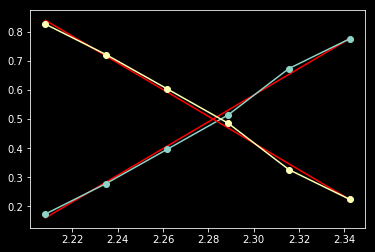

In [0]:
from scipy.optimize import curve_fit

def func(x, a, b):
     return (a * x) + b

popt1, pcov = curve_fit(func, X.ravel()[45:51], avg_ext[45:51,0])
plt.plot(X.ravel()[45:51], func(X.ravel()[45:51], *popt1), 'r-')
plt.plot(X.ravel()[45:51], avg_ext[45:51,0],'-o')
print(popt1)

popt2, pcov = curve_fit(func, X.ravel()[45:51], avg_ext[45:51,1])
plt.plot(X.ravel()[45:51], func(X.ravel()[45:51], *popt2), 'r-')
plt.plot(X.ravel()[45:51], avg_ext[45:51,1],'-o')
print(popt2)

In [0]:
pred = (popt2[1]-popt1[1])/(popt1[0]-popt2[0])
value = 2/np.log(1+np.sqrt(2))
print('valore predetto:',pred)
print('valore teorico:',value)
print('differenza:',abs(pred-value))

valore predetto: 2.2820320326715815
valore teorico: 2.269185314213022
differenza: 0.012846718458559447
